Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [24]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [40]:
import numpy as np

import random

import thinkstats2
import thinkplot

from thinkstats2 import Mean, MeanVar, Var, Std, Cov


Here's the least squares fit to birth weight as a function of mother's age.

**Exercise:9.1** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [41]:
# Solution
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

def RunTests(live, iters=2000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [42]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [43]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [44]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [45]:
# Solution

n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.17	0.00	0.00	0.00
4574	0.41	0.00	0.00	0.00
2287	0.29	0.57	0.00	0.00
1143	0.18	0.44	0.14	0.06
571	0.17	0.82	0.37	0.00
285	0.35	0.05	0.30	0.27
142	0.28	0.26	0.72	0.05


In [46]:
# Solution

#results:

# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length


# Conclusion: As expected, tests that are positive with large sample
# sizes become negative as we take away data.  But the pattern is
# erratic, with some positive tests even at small sample sizes.

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [47]:
# Solution

class DiffMeansResample(DiffMeansPermute):
    """Tests a difference in means using resampling."""
    
    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

In [48]:
# Solution

def RunResampleTest(firsts, others):
    """Tests differences in means by resampling.

    firsts: DataFrame
    others: DataFrame
    """
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample preglength')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample birthweight')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

In [49]:
# Solution

RunResampleTest(firsts, others)


diff means resample preglength
p-value = 0.1672
actual = 0.07803726677754952
ts max = 0.27036735803380196

diff means resample birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.110886495702192


In [50]:
# Solution

# Conclusions: Using resampling instead of permutation has very
# little effect on the results.

# The two models are based on slightly difference assumptions, and in
# this example there is no compelling reason to choose one or the other.
# But in general p-values depend on the choice of the null hypothesis;
# different models can yield very different results.

**Exercise:10.1** Use `ResampleRows` and generate a list of estimates for the mean birth weight.  Use `Summarize` to compute the SE and CI for these estimates.

In [51]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [52]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [53]:
# Solution
estimates=[]
for i in range(2000):
  estimates.append(ResampleRows(live).totalwgt_lb.mean())

Summarize(estimates)

mean, SE, CI 7.265628764684665 0.014795138547070137 (7.241060555740064, 7.290560941828255)


**Exercise:10.2** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [54]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [55]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [56]:

x_mean, x_var = MeanVar(heights)
y_mean = Mean(log_weights)

slope = Cov(heights, log_weights, x_mean, y_mean) / x_var
intercept = y_mean - slope * x_mean

print ('Intercept:', intercept)
print ('Slope:', slope)

Intercept: 0.9930804163918064
Slope: 0.005281454169417842


Make a scatter plot of the data and show the fitted line.

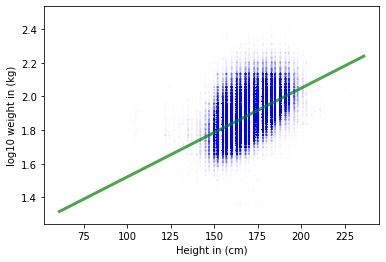

In [57]:
# Solution

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fit_x, fit_y = thinkstats2.FitLine(heights, intercept, slope)
thinkplot.Plot(fit_x, fit_y, color='green')
thinkplot.Config(xlabel='Height in (cm)', ylabel='log10 weight in (kg)', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

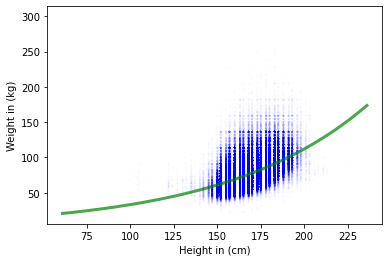

In [58]:
# Solution

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fit_x, fit_y = thinkstats2.FitLine(heights, intercept, slope)
thinkplot.Plot(fit_x, 10**fit_y, color='green')
thinkplot.Config(xlabel='Height in (cm)', ylabel='Weight in (kg)', legend=False)

Plot percentiles of the residuals.

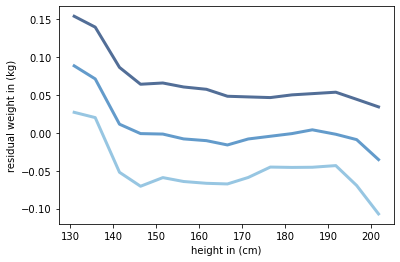

In [61]:
# Solution

residual = thinkstats2.Residuals(heights, log_weights, intercept, slope)
df['residual'] = residual

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

mean=[]
cdf=[]
for i, group in groups:
  mean.append(group.htm3.mean())
  means=mean[1:-1]
  
  cdf.append(thinkstats2.Cdf(group.residual))
  cdfs=cdf[1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height in (cm)', ylabel='residual weight in (kg)', legend=False)

Compute correlation.

In [62]:
# Solution

rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983464

Compute coefficient of determination.

In [64]:
r2 = thinkstats2.CoefDetermination(log_weights, residual)
r2

0.2827349431189352

Confirm that $R^2 = \rho^2$.

In [65]:
# Solution

np.isclose(rho**2, r2)

True

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [66]:
# Solution

std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004853

Compute Std(res), the RMSE of predictions that do use height.

In [68]:
# Solution

std_res = thinkstats2.Std(residual)
std_res

0.08740777080416083

How much does height information reduce RMSE?

In [69]:
# Solution

1 - std_res / std_ys

0.1530849765879313

Use resampling to compute sampling distributions for inter and slope.

In [70]:
t = []
for i in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

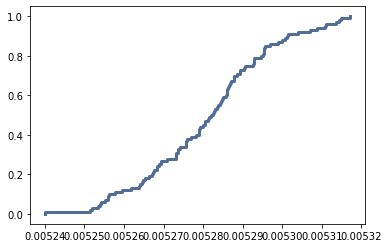

In [71]:
# Solution

cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [72]:
# Solution

pvalue = cdf[0]
pvalue

0

Compute the 90% confidence interval of slope.

In [73]:
# Solution

ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005253894655573758, 0.0053109070580730664)

Compute the mean of the sampling distribution.

In [74]:
# Solution

mean = thinkstats2.Mean(slopes)
mean

0.005281120343327014

Compute the standard deviation of the sampling distribution, which is the standard error.

In [75]:
# Solution

stderr = thinkstats2.Std(slopes)
stderr

1.6165050091977033e-05

Resample rows without weights, compute mean height, and summarize results.

In [76]:
# Solution

est_unweight=[]
for i in range(200):
 est_unweight.append(thinkstats2.ResampleRows(df).htm3.mean())
Summarize(est_unweight)

mean, SE, CI 168.956949753936 0.01684696991627491 (168.93153661149174, 168.98418520988702)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [77]:
# Solution
est_weight=[]
for i in range(200):
    weight = df['finalwt']
    cdf = thinkstats2.Cdf(dict(weight))
    indices = cdf.Sample(len(weight))
    sample = df.loc[indices]
    est_weight.append(sample.htm3.mean())

Summarize(est_weight)

mean, SE, CI 170.49579018371426 0.01552411295595958 (170.47005042543302, 170.51966490834496)
